# SNL Data Exploration Notebook

## Imports

In [209]:
from functools import cache, cached_property
from pathlib import Path
from dataclasses import dataclass

import pandas as pd
import numpy as np

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
from typing import Tuple

## Data

The data is sourced from this [Kaggle dataset](https://www.kaggle.com/datasets/hhllcks/snldb) which was originally generated using [this scrapy tool](https://github.com/hhllcks/snldb). Unfortunately, the website with the ground truth source, the [SNL Archives](http://www.snlarchives.net), changed its layout sometime in the last 3 years and the scraper hasn't been updated. Getting new data will require significant updates and it might be easier just to build a new parser.

In [349]:
class Data:
    """
    ## Data
    This class handles loading the raw data and providing useful or convenient views. It makes
    extensive use of the `@cached_property` decorator, which lazily evaluates the first time it
    is run and then stores the value after.

    Where relevant, the loaded tables are sorted and indexed.
    """
    
    DATA_DIR = Path("data/")

    @cached_property
    def actors(self):
        return pd.read_csv(self.DATA_DIR / "actors.csv")\
          .set_index("aid")

    @cached_property
    def appearances(self):
        return pd.read_csv(self.DATA_DIR / "appearances.csv")\
          .sort_values("epid")

    @cached_property
    def casts(self):
        return pd.read_csv(self.DATA_DIR / "casts.csv")\
          .sort_values("sid")

    @cached_property
    def characters(self):
        return pd.read_csv(self.DATA_DIR / "characters.csv")\
          .sort_values("charid")\
          .set_index("charid")

    @cached_property
    def episodes(self):
        return pd.read_csv(self.DATA_DIR / "episodes.csv")\
          .sort_values("epid")\
          .set_index("epid")

    @cached_property
    def hosts(self):
        return pd.read_csv(self.DATA_DIR / "hosts.csv")\
          .sort_values("epid")

    @cached_property
    def impressions(self):
        return pd.read_csv(self.DATA_DIR / "impressions.csv")\
          .sort_values("impid")\
          .set_index("impid")

    @cached_property
    def seasons(self):
        return pd.read_csv(self.DATA_DIR / "seasons.csv")\
          .sort_values("sid")\
          .set_index("sid")

    @cached_property
    def sketches(self):
        return pd.read_csv(self.DATA_DIR / "sketches.csv")\
          .sort_values("skid")\
          .set_index("skid")

    @cached_property
    def tenure(self):
        return pd.read_csv(self.DATA_DIR / "tenure.csv")\
          .sort_values("aid")

    @cached_property
    def titles(self):
        return pd.read_csv(self.DATA_DIR / "titles.csv")\
          .sort_values("tid")\
          .set_index("tid")

    @cached_property
    def actors_tenure(self):
        return self.tenure.join(data.actors, on="aid", how="inner")\
          .set_index("aid")
        
    @cached_property
    def actors_casts(self):
        return self.casts.join(data.actors, on="aid", how="left")\
          .set_index("aid")
        
    @property
    def all_seasons(self):
        return self.seasons.index
        
    @cached_property
    def turnover_rates(self):
        data = []
        last_cast = {
            "total": set(),
            "female": set(),
            "male": set(),
        }
        for sid in self.all_seasons:
            df = self.season_cast(sid)
            cast = {
                "total": set(df.aid),
                "female": set(df[df.gender == "female"].aid),
                "male": set(df[df.gender == "male"].aid),
            }
            dropped = {
                key: last_cast[key] - cast[key]
                for key in "total female male".split()
            }

            data.append({
                "sid": sid,
                **{
                    f"{key}_turnover": len(dropped[key]) / (len(last_cast[key]) or 1)
                    for key in "total female male".split()
                },
                **{
                    f"{key}_number_dropped": len(dropped[key])
                    for key in "total female male".split()
                }
            })
            
            last_cast = cast
        return pd.DataFrame(data).set_index("sid")
        
    @cached_property
    def gender_counts(self):
        data = []
        for sid in self.all_seasons:
            cast = self.season_df(self.actors_casts, sid)

            data.append({
                "sid": sid,
                "female_count": len(cast[cast.gender == "female"]),
                "male_count": len(cast[cast.gender == "male"]),
            }) 

        df = pd.DataFrame(data)
        df["cast_size"] = df["female_count"] + df["male_count"]
        df["female_ratio"] = df["female_count"] / df["cast_size"]
        return df.set_index("sid")

    @cached_property
    def weighted_gender_counts(self):
        data = []
        for sid in self.all_seasons:
            cast = self.season_df(self.actors_casts, sid)\
                     .join(self.actors_tenure.n_seasons, on="aid")

            data.append({
                "sid": sid,
                "female_weight": sum(cast[cast.gender == "female"].n_seasons),
                "male_weight": sum(cast[cast.gender == "male"].n_seasons),
            }) 

        df = pd.DataFrame(data)
        df["cast_weight"] = df["female_weight"] + df["male_weight"]
        df["female_ratio"] = df["female_weight"] / df["cast_weight"]
        return df.set_index("sid")

    @cache
    def season_cast(self, season: int):
        return self.season_df(self.casts, season)\
          [["aid", "sid", "featured", "update_anchor", "n_episodes", "season_fraction"]]\
          .sort_values("aid")\
          .join(data.actors.gender, how="left", on="aid")

    def season_df(self, df: pd.DataFrame, season: int):
        return df[df.sid == season]

In [347]:
data = Data()
data.actors

,url,type,gender
aid,,,
Kate McKinnon,/Cast/?KaMc,cast,female
Alex Moffat,/Cast/?AlMo,cast,male
Ego Nwodim,/Cast/?EgNw,cast,unknown
Chris Redd,/Cast/?ChRe,cast,male
Kenan Thompson,/Cast/?KeTh,cast,male
...,...,...,...
Jesse Dixon Singers,/Guests/?16,guest,male
Connie Hawkins,/Guests/?21,guest,female
Billy Preston,/Guests/?3,guest,male


In [348]:
data.season_cast(3)

,aid,sid,featured,update_anchor,n_episodes,season_fraction,gender
442,Al Franken,3,True,False,20,1.0,male
230,Bill Murray,3,False,False,20,1.0,male
601,Dan Aykroyd,3,False,True,20,1.0,male
248,Garrett Morris,3,False,False,20,1.0,male
154,Gilda Radner,3,False,False,20,1.0,female
536,Jane Curtin,3,False,True,20,1.0,female
586,John Belushi,3,False,False,20,1.0,male
210,Laraine Newman,3,False,False,20,1.0,female
523,Tom Davis,3,True,False,20,1.0,male


## Charts

In [350]:
@dataclass
class Charts:
    """
    ## Charts
    This class handles generating the Seaborn/Matplotlib charts. It's initialized with the data
    and settings needed to produce them consistently.
    """
    
    data: Data
    figure_size: Tuple[int, int]
    theme: str
    palette: str

    def __post_init__(self):
        sns.set_theme(
            context="notebook",
            style=self.theme,
            palette=self.palette,
            font="sans-serif",
        )

    def _make_axes(self):
        fig, ax = plt.subplots()
        fig.set_size_inches(*self.figure_size)
        return ax
    
    @property
    def dist_cast_tenure_ep(self):
        ax = self._make_axes()
        ax.set_title("Distribution of Cast Tenure (Episodes)")
        ax.set_xlabel("Length of Tenure (Episodes)")
        
        chart_data = self.data.tenure.n_episodes
        return sns.histplot(
            chart_data,
            bins=20,
            stat="frequency",
            kde=True,
            ax=ax,
        )
    
    @property
    def dist_cast_tenure_se(self):
        ax = self._make_axes()
        ax.set_title("Distribution of Cast Tenure (Seasons)")
        ax.set_xlabel("Length of Tenure (Seasons)")
        
        chart_data = self.data.tenure.n_seasons
        return sns.histplot(
            chart_data,
            bins=12,
            stat="frequency",
            kde=True,
            ax=ax,
        )
    
    @property
    def turnover_rate(self):
        ax = self._make_axes()
        ax.set_title("Turnover Rate of SNL Cast Members Across Seasons")
        ax.set_ylabel("Turnover Rate")
        ax.set_xlabel("Season")
        ax.set_xticks(self.data.all_seasons)
        ax.tick_params(axis="x", rotation=45, labelsize=10)
        
        sns.lineplot(
            self.data.turnover_rates.total_turnover,
            marker="o",
            linestyle="-",
            linewidth=2.5,
            ax=ax,
        )
        return ax

    @property
    def gender_ratio(self):
        ax = self._make_axes()
        ax.set_title("Gender Ratio of SNL Cast Members Across Seasons")
        ax.set_ylabel("Female Ratio")
        ax.set_xlabel("Season")
        ax.set_xticks(self.data.all_seasons)
        ax.tick_params(axis="x", rotation=45, labelsize=10)
    
        chart_data = self.data.gender_counts.female_ratio
        return sns.lineplot(
            chart_data,
            marker="o",
            linestyle="-",
            linewidth=2.5,
            ax=ax,
        )

    @property
    def tenure_weighted_gender_ratio(self):
        ax = self._make_axes()
        ax.set_title("Gender Ratio of SNL Cast Members Across Seasons, Weighted by Tenure")
        ax.set_ylabel("Female Ratio")
        ax.set_xlabel("Season")
        ax.set_xticks(self.data.all_seasons)
        ax.tick_params(axis="x", rotation=45, labelsize=10)
    
        chart_data = self.data.weighted_gender_counts.female_ratio
        return sns.lineplot(
            chart_data,
            marker="o",
            linestyle="-",
            linewidth=2.5,
            ax=ax,
        )

    @property
    def gender_counts(self):
        ax = self._make_axes()
        ax.set_title("Number of Male and Female Cast Members Per Season")
        ax.set_ylabel("Number of Cast Members")
        ax.set_xlabel("Season")
        ax.set_xticks(self.data.all_seasons)
        ax.tick_params(axis="x", rotation=45, labelsize=10)
    
        ax.stackplot(
            self.data.gender_counts.index,
            self.data.gender_counts.female_count,
            self.data.gender_counts.male_count,
            labels=["Female", "Male"],
            colors=["mediumorchid", "royalblue"],
            alpha=0.8,
        )
        ax.legend(loc="upper left", title="Gender", title_fontsize=13, fontsize=12)
        return ax

    @property
    def gender_turnover(self):
        ax = self._make_axes()
        ax.set_title("Number of Male and Female Cast Members who Left per Season")
        ax.set_ylabel("Number of Cast Members")
        ax.set_xlabel("Season")
        ax.set_xticks(self.data.all_seasons)
        ax.tick_params(axis="x", rotation=45, labelsize=10)
    
        ax.stackplot(
            self.data.turnover_rates.index,
            self.data.turnover_rates.female_number_dropped,
            self.data.turnover_rates.male_number_dropped,
            labels=["Female", "Male"],
            colors=["mediumorchid", "royalblue"],
            alpha=0.8,
        )
        ax.legend(loc="upper left", title="Gender", title_fontsize=13, fontsize=12)
        return ax

    @property
    def all_charts(self):
        return [
            self.dist_cast_tenure_ep,
            self.dist_cast_tenure_se,
            self.turnover_rate,
            self.gender_counts,
            self.gender_turnover,
            self.gender_ratio,
            self.tenure_weighted_gender_ratio,
        ]

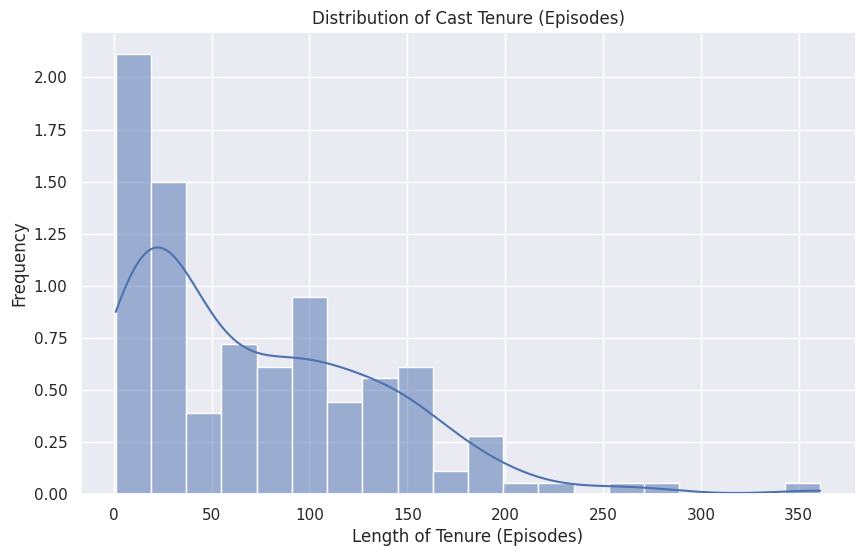

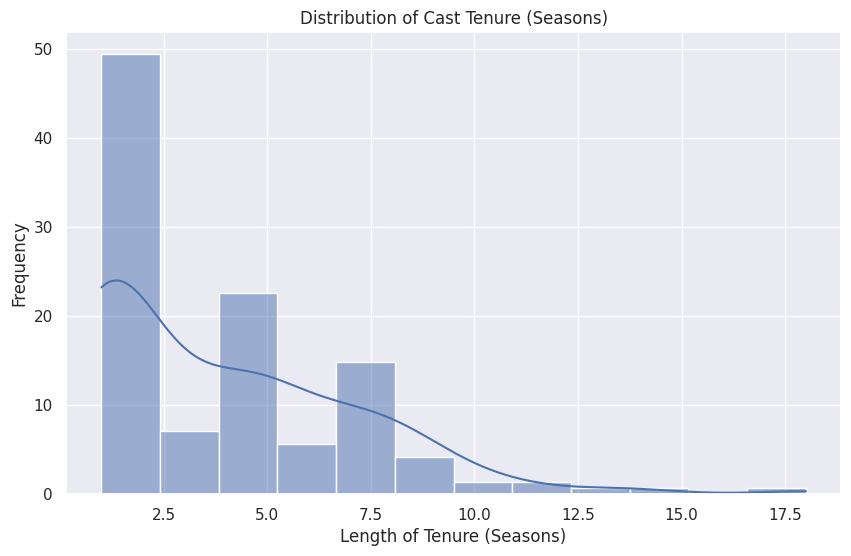

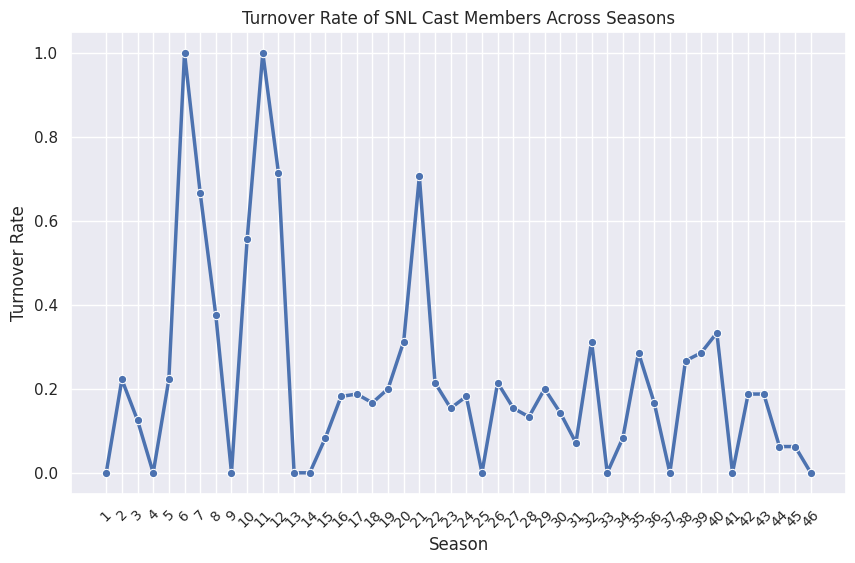

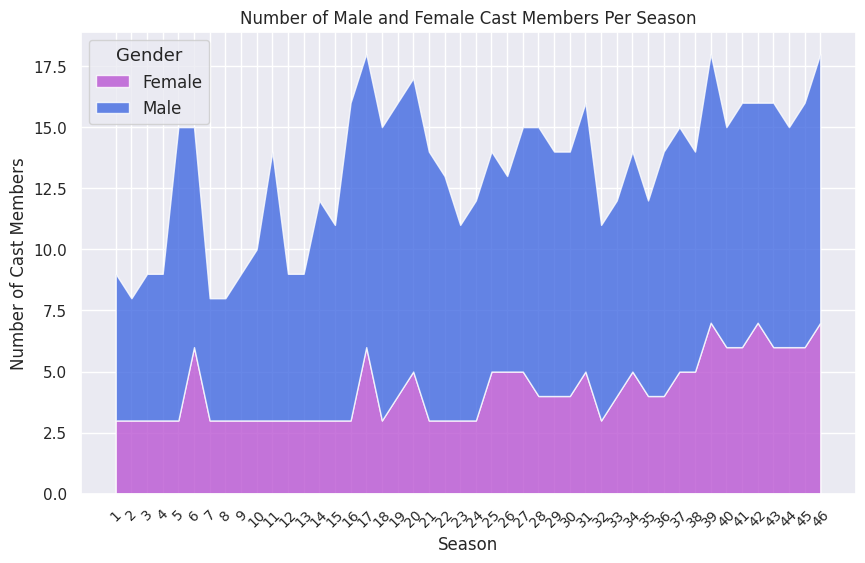

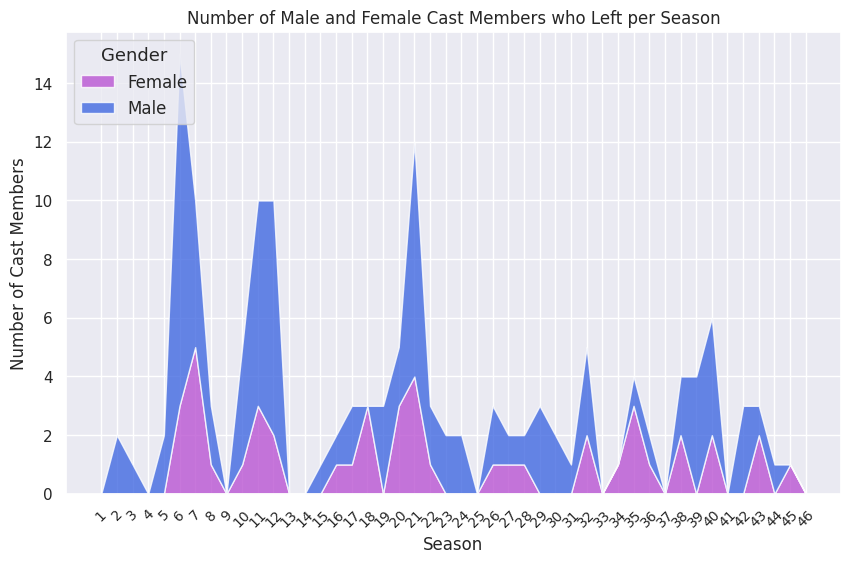

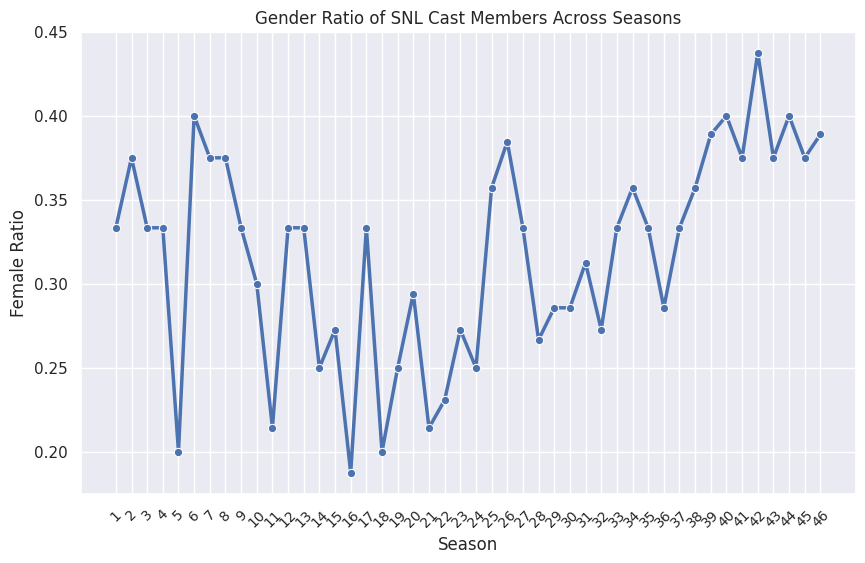

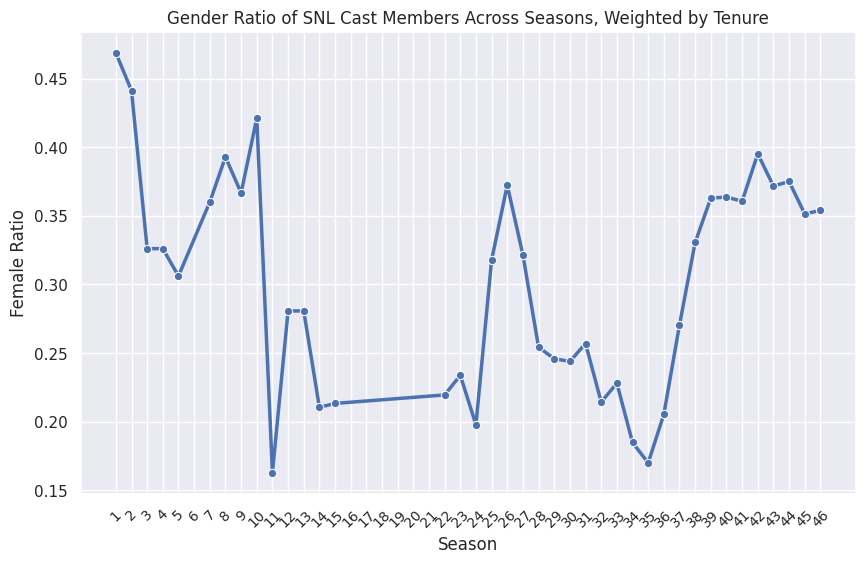

In [346]:
charts = Charts(
    data=Data(),
    figure_size=(10, 6),
    theme="darkgrid",
    palette="deep",
)
charts.all_charts
plt.show()